In [1]:
import xskillscore as xs

In [2]:
import xarray as xr
import numpy as np

from xhistogram.xarray import histogram as xhist

from dask.distributed import Client

In [3]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit=3e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39291,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:42907,Total threads: 2
Dashboard: http://127.0.0.1:42695/status,Memory: 2.79 GiB
Nanny: tcp://127.0.0.1:43197,


In [4]:
ds = xr.open_dataset("data.nc", chunks={
    "t": -1,  # this is not ideal
    "y": 90,
    "x": 90,
})
ds

<xarray.Dataset>
Dimensions:  (t: 365, y: 180, x: 360)
Coordinates:
  * t        (t) int64 0 1 2 3 4 5 6 7 8 ... 356 357 358 359 360 361 362 363 364
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 171 172 173 174 175 176 177 178 179
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
Data variables:
    A        (t, y, x) float64 dask.array<chunksize=(365, 90, 90), meta=np.ndarray>
    B        (t, y, x) float64 dask.array<chunksize=(365, 90, 90), meta=np.ndarray>

In [5]:
bootstrapped = xs.resample_iterations(ds, 100, "t").mean("t")
bootstrapped

<xarray.Dataset>
Dimensions:    (y: 180, x: 360, iteration: 100)
Coordinates:
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    A          (y, x, iteration) float64 dask.array<chunksize=(90, 90, 1), meta=np.ndarray>
    B          (y, x, iteration) float64 dask.array<chunksize=(90, 90, 1), meta=np.ndarray>

In [6]:
# ranges (persist for allowing to re-use data reads)
A0, A1 = ds.A.min().persist(), ds.A.max().persist()
B0, B1 = ds.B.min().persist(), ds.B.max().persist()

# np will trigger a compute of the bounds
A_bins = np.linspace(A0, A1, 301)
B_bins = np.linspace(B0, B1, 301)

In [7]:
A_hist = xhist(bootstrapped.A, bins=A_bins, dim=["iteration", ])
B_hist = xhist(bootstrapped.B, bins=B_bins, dim=["iteration", ])

In [8]:
A_hist = A_hist.persist()
B_hist = B_hist.persist()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


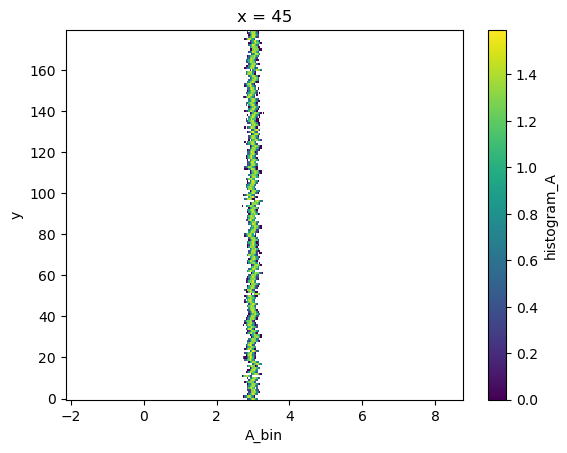

In [9]:
np.log10(A_hist.compute().isel(x=45)).plot();

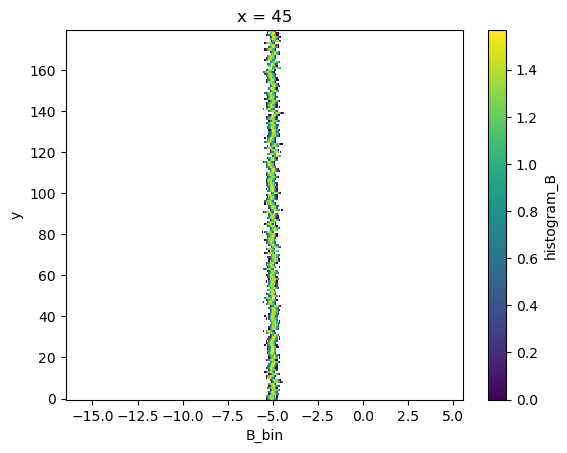

In [10]:
np.log10(B_hist.compute().isel(x=45)).plot();